1. 라이브러리 importing 

In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import csv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 텐서플로에서 ERROR, INFO, WARNING 로그를 출력하는 방법 -> 2 = INFO and WARNING messages are not printed

2. 데이터셋 생성을 위한 함수. 본 파일에선 Python generator를 응용한 데이터셋 구성 방법을 사용하였습니다.

In [2]:
np.set_printoptions(precision=4, suppress=True) 

LABEL_COLUMN = 'nlos'
LABELS = [0, 1] # 출력결과 NLOS -> 0 or 1

def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=32, # batch: 모델의 가중치를 업데이트하는 샘플 단위
      label_name=LABEL_COLUMN,
      na_value="?", # NA/NaN으로 인식할 문자열
      num_epochs=1, # 학습횟수
      ignore_errors=True,  #오류를 무시하고 다음 유효 CSV레코드로 이동
      shuffle=True, # 입력 셔플 X
      **kwargs)
  return dataset

def show_batch(dataset): #각 열의 항목(배치)를 보여줌
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

def pack(features, label): #모든 열들을 묶어줌
  return tf.stack(list(features.values()), axis=-1), label

3. 위 함수의 매개변수로 전달되는 CSV 파일에서 학습에 사용할 열을 지정합니다.

In [3]:
SELECT_COLUMNS = ["nlos",\
                  "SNR main path 1", "SNR main path 2", "SNR main path 3", "SNR main path 4",\
                  "SNR first path 1","SNR first path 2","SNR first path 3","SNR first path 4",\
                  "SNR Total 1","SNR Total 2","SNR Total 3","SNR Total 4",\
                  "RSSI 1","RSSI 2","RSSI 3","RSSI 4",\
                  "CIR main power 1","CIR main power 2","CIR main power 3","CIR main power 4",\
                  "CIR first path power 1","CIR first path power 2","CIR first path power3","CIR first path power 4",\
                  "Noise variance 1","Noise variance 2","Noise variance 3","Noise variance 4"]      # 열 이름
DEFAULTS       = [0.0,\
                  0.0, 0.0, 0.0, 0.0,\
                  0.0, 0.0, 0.0, 0.0,\
                  0.0, 0.0, 0.0, 0.0,\
                  0.0, 0.0, 0.0, 0.0,\
                  0.0, 0.0, 0.0, 0.0,\
                  0.0, 0.0, 0.0, 0.0,\
                  0.0, 0.0, 0.0, 0.0] # 열 기본 값  설정

raw_train_data = get_dataset("./dnn_input/master_train.csv", 
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)
raw_val_data = get_dataset("./dnn_input/validation.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)

4. 2에서 정의한 함수를 기반으로 데이터 셋을 생성합니다.

In [4]:
train_batch, train_labels_batch = next(iter(raw_train_data)) # iter : 반복을 이용해 어떠한 처리를 수행하는 호출가능 객체, next: 반복 수행 요청
val_batch, val_labels_batch = next(iter(raw_val_data))
# test_batch, test_labels_batch = next(iter(raw_test_data))
    
packed_dataset = raw_train_data.map(pack)
packed_val_dataset = raw_val_data.map(pack)
# packed_test_dataset = raw_test_data.map(pack)

5. 딥러닝 모델을 구성합니다. mirrored_strategy 부분은 다수의 GPU를 사용하기 위한 코드로 선택적으로 사용하시면 됩니다.

In [5]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.001) # Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension

mirrored_strategy = tf.distribute.MirroredStrategy()


with mirrored_strategy.scope():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,)),
    tf.keras.layers.Dense(56,activation='tanh'), # 노드 수 : 56, input 차원 : 28
    tf.keras.layers.Dense(112,activation='tanh'), # 노드 수 : 112, input 차원 : 56
    tf.keras.layers.Dense(56, activation='tanh'), # 노드 수 : 56, input 차원 : 112
    tf.keras.layers.Dense(1,activation='sigmoid'), # 노드 수 : 1, input 차원 : 56
    ])


    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=opt,
        metrics=['accuracy'])
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                1624      
                                                                 
 dense_1 (Dense)             (None, 112)               6384      
                                                                 
 dense_2 (Dense)             (None, 56)                6328      
                                                                 
 dense_3 (Dense)             (None, 1)                 57        
                                                                 
Total params: 14,393
Trainable params: 14,393
Non-trainable params: 0
_________________________________________________________________


6. 학습을 위해 데이터 셋을 한 번 더 지정하고, 실시간으로 학습 상황을 파악하기위해 Tensorboard Callback을 선언합니다.

In [6]:
train_data = packed_dataset
val_data = packed_val_dataset

# Define the Keras TensorBoard callback.
logdir="./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

7. 학습을 수행합니다. 아래 함수의 매개변수 설명은 Keras 또는 Tensorflow 공식 문서를 참고하시기 바랍니다.

In [7]:
history = model.fit(train_data, epochs=120, validation_data = val_data,verbose = 2, use_multiprocessing=True, workers=8, callbacks=[tensorboard_callback],shuffle=True)

Epoch 1/120


c:\Users\UnLab\anaconda3\envs\ws\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1164/1164 - 7s - loss: 0.7914 - accuracy: 0.3606 - val_loss: 0.6761 - val_accuracy: 0.5928 - 7s/epoch - 6ms/step
Epoch 2/120
1164/1164 - 2s - loss: 0.5960 - accuracy: 0.8165 - val_loss: 0.5268 - val_accuracy: 0.8476 - 2s/epoch - 2ms/step
Epoch 3/120
1164/1164 - 2s - loss: 0.4636 - accuracy: 0.8625 - val_loss: 0.4213 - val_accuracy: 0.8811 - 2s/epoch - 2ms/step
Epoch 4/120
1164/1164 - 2s - loss: 0.3701 - accuracy: 0.9010 - val_loss: 0.3464 - val_accuracy: 0.9366 - 2s/epoch - 2ms/step
Epoch 5/120
1164/1164 - 2s - loss: 0.3051 - accuracy: 0.9435 - val_loss: 0.2941 - val_accuracy: 0.9423 - 2s/epoch - 2ms/step
Epoch 6/120
1164/1164 - 2s - loss: 0.2602 - accuracy: 0.9458 - val_loss: 0.2574 - val_accuracy: 0.9437 - 2s/epoch - 2ms/step
Epoch 7/120
1164/1164 - 2s - loss: 0.2292 - accuracy: 0.9483 - val_loss: 0.2322 - val_accuracy: 0.9483 - 2s/epoch - 2ms/step
Epoch 8/120
1164/1164 - 2s - loss: 0.2083 - accuracy: 0.9514 - val_loss: 0.2150 - val_accuracy: 0.9545 - 2s/epoch - 2ms/step
Epoch 9/120


KeyboardInterrupt: 

8. 학습이 완료된 후 학습된 모델을 h5 형식으로 저장합니다.

In [8]:
model.save("HH01.h5")

9. 학습된 모델의 정확한 검증을 위해 Test데이터를 새롭게 불러옵니다.

In [26]:
raw_test_data1 = get_dataset("./dnn_input/senario1_test.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)
raw_test_data2 = get_dataset("./dnn_input/senario2_test.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)
raw_test_data3 = get_dataset("./dnn_input/senario3_test.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)
raw_test_data4 = get_dataset("./dnn_input/senario4_test.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)
raw_test_data5 = get_dataset("./dnn_input/senario5_test.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)
raw_test_data6 = get_dataset("./dnn_input/senario6_test.csv",
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)

test_batch1, test_labels_batch1 = next(iter(raw_test_data1))
packed_test_dataset1 = raw_test_data1.map(pack)

test_batch2, test_labels_batch2 = next(iter(raw_test_data2))
packed_test_dataset2 = raw_test_data2.map(pack)

test_batch3, test_labels_batch3 = next(iter(raw_test_data3))
packed_test_dataset3 = raw_test_data3.map(pack)

test_batch4, test_labels_batch4 = next(iter(raw_test_data4))
packed_test_dataset4 = raw_test_data4.map(pack)

test_batch5, test_labels_batch5 = next(iter(raw_test_data5))
packed_test_dataset5 = raw_test_data5.map(pack)

test_batch6, test_labels_batch6 = next(iter(raw_test_data6))
packed_test_dataset6 = raw_test_data6.map(pack)


10. Test데이터를 기반으로 예측을 수행하고 통합 결과를 출력합니다.

In [31]:
test_loss1, test_accuracy1 = model.evaluate(packed_test_dataset1)

print('Test Loss {}, Test Accuracy {}\n'.format(test_loss1, test_accuracy1))

test_loss2, test_accuracy2 = model.evaluate(packed_test_dataset2)

print('Test Loss {}, Test Accuracy {}\n'.format(test_loss2, test_accuracy2))

test_loss3, test_accuracy3 = model.evaluate(packed_test_dataset3)

print('Test Loss {}, Test Accuracy {}\n'.format(test_loss3, test_accuracy3))

test_loss4, test_accuracy4 = model.evaluate(packed_test_dataset4)

print('Test Loss {}, Test Accuracy {}\n'.format(test_loss4, test_accuracy4))

test_loss5, test_accuracy5 = model.evaluate(packed_test_dataset5)

print('Test Loss {}, Test Accuracy {}\n'.format(test_loss5, test_accuracy5))

test_loss6, test_accuracy6 = model.evaluate(packed_test_dataset6)

print('Test Loss {}, Test Accuracy {}\n'.format(test_loss6, test_accuracy6))

34/34 [==============================] - 0s 1ms/step - loss: 0.5977 - accuracy: 0.7927
Test Loss 0.5977470874786377, Test Accuracy 0.792682945728302

23/23 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 1.0000
Test Loss 0.0219393502920866, Test Accuracy 1.0

31/31 [==============================] - 0s 1ms/step - loss: 0.0452 - accuracy: 0.9990
Test Loss 0.04519135504961014, Test Accuracy 0.9989733099937439

43/43 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 1.0000
Test Loss 0.02355482615530491, Test Accuracy 1.0

32/32 [==============================] - 0s 1ms/step - loss: 0.0412 - accuracy: 0.9960
Test Loss 0.04120224714279175, Test Accuracy 0.9960317611694336

28/28 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 1.0000
Test Loss 0.03318975493311882, Test Accuracy 1.0



11. 학습 결과를 그래프로 출력합니다.

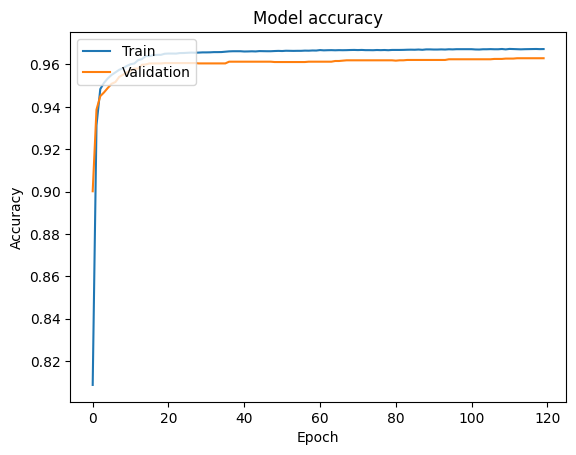

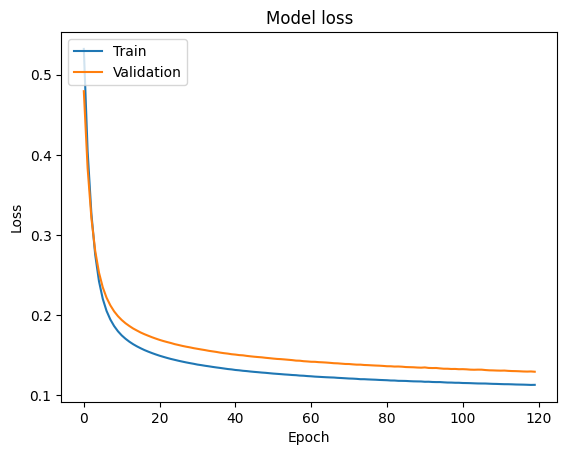

In [32]:
import matplotlib.pyplot as plt

#print(history.history)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()